For a full explanation of the code, visit http://ataspinar.com/2017/12/04/using-convolutional-neural-networks-to-detect-features-in-sattelite-images/

In [3]:
import sys
sys.path.insert(0,'..')

import os
import json
import pickle
import requests
import shutil
import random
import numpy as np

from collections import defaultdict
from scipy import ndimage
from datetime import date
from datetime import datetime

import matplotlib.pyplot as plt

#We are using owslib to download images from a WMS Service
#install with 'pip install owslib'

import owslib

from owslib.wms import WebMapService

#pyshp is necessary for loading and saving shapefiles
#install with 'pip install pyshp'
import shapefile

# Install opencv with 'pip install opencv-python'
import cv2

In [4]:
x_min = 90000
y_min = 427000
dx, dy = 200, 200
no_tiles_x = 100
no_tiles_y = 100
total_no_tiles = no_tiles_x * no_tiles_y

x_max = x_min + no_tiles_x * dx
y_max = y_min + no_tiles_y * dy
bounding_box = [x_min, y_min, x_max, y_max]

TILE_FOLDER = "./datasets/image_tiles_200/"
URL_TILES = "https://geodata.nationaalgeoregister.nl/luchtfoto/rgb/wms?request=GetCapabilities"

URL_SHP = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.shp'
URL_PRF = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.prj'
URL_DBF = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.dbf'
URL_SHX = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.shx'

URLS_SHAPEFILES = [URL_SHP, URL_PRF, URL_DBF, URL_SHX]

DATA_FOLDER = "./data/nwb_wegvakken/"

json_filename = DATA_FOLDER + '2017_09_wegvakken.json'

# 1. Downloading the image tiles

In [ ]:
#Skip if you already have the image tiles. Will take ~ 2hours.
wms = WebMapService(URL_TILES, version='1.1.1')

if not os.path.exists(TILE_FOLDER):
    os.makedirs(TILE_FOLDER)

for ii in range(0,25):
    print(ii)
    for jj in range(0,no_tiles_y):
        ll_x_ = x_min + ii*dx
        ll_y_ = y_min + jj*dy
        bbox = (ll_x_, ll_y_, ll_x_ + dx, ll_y_ + dy) 
        img = wms.getmap(layers=['Actueel_ortho25'], srs='EPSG:28992', bbox=bbox, size=(256, 256), format='image/jpeg', transparent=True)
        filename = "{}{}_{}_{}_{}.jpg".format(TILE_FOLDER, bbox[0], bbox[1], bbox[2], bbox[3])
        out = open(filename, 'wb')
        out.write(img.read())
        out.close()


## 1b. Downloading the shapefiles

In [ ]:
#Skip if you already have the shapefiles. Will take ~ 1hour.
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

for url in URLS_SHAPEFILES:
    filename = url.split('/')[-1]
    print("Downloading file {}".format(filename))
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(DATA_FOLDER + filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)     

# 2. Loading shapefile and converting to (GEO)Json

In [ ]:
# Skip if conversion already done and "json_filename" already saved
def json_serial(obj):
    """JSON serializer for objects not serializable by default json code"""

    if isinstance(obj, (datetime, date)):
        serial = obj.isoformat()
        return serial
    if isinstance(obj, bytes):
        return {'__class__': 'bytes',
                '__value__': list(obj)}
    raise TypeError ("Type %s not serializable" % type(obj))

reader = shapefile.Reader(DATA_FOLDER + 'Wegvakken.shp')
fields = reader.fields[1:]
field_names = [field[0] for field in fields]

buffer = []
for sr in reader.shapeRecords()[:500000]:
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", geometry=geom, properties=atr)) 


json_file = open(json_filename, "w")
json_file.write(json.dumps({"type": "FeatureCollection", "features": buffer}, indent=2, default=json_serial) + "\n")
json_file.close()

# 3. Declaring some variables and methods

In [ ]:
dict_roadtype = {
    "G": 'Gemeente',
    "R": 'Rijk',
    "P": 'Provincie',
    "W": 'Waterschap',
    'T': 'Andere wegbeheerder',
    '' : 'leeg'
}

dict_roadtype_to_color = {
    "G": 'red',
    "R": 'blue',
    "P": 'green',
    "W": 'magenta',
    'T': 'yellow',
    '' : 'leeg'
}

FEATURES_KEY = 'features'
PROPERTIES_KEY = 'properties'
GEOMETRY_KEY = 'geometry'
COORDINATES_KEY = 'coordinates'
WEGSOORT_KEY = 'WEGBEHSRT'

MINIMUM_NO_POINTS_PER_TILE = 4
POINTS_PER_METER = 10 # Changed by David from 0.1

INPUT_FOLDER_TILES = './datasets/image_tiles_200/'

In [ ]:
def add_to_dict(d1, d2, coordinates, rtype):
    coordinate_ll_x = int((coordinates[0] // dx)*dx)
    coordinate_ll_y = int((coordinates[1] // dy)*dy)
    coordinate_ur_x = int((coordinates[0] // dx)*dx + dx)
    coordinate_ur_y = int((coordinates[1] // dy)*dy + dy)
    tile = "{}_{}_{}_{}.jpg".format(coordinate_ll_x, coordinate_ll_y, coordinate_ur_x, coordinate_ur_y)
    
    rel_coord_x = (coordinates[0] - coordinate_ll_x) / dx
    rel_coord_y = (coordinates[1] - coordinate_ll_y) / dy
    value = (rtype, rel_coord_x, rel_coord_y)
    d1[tile].append(value)
    d2[rtype].add(tile)

def coord_is_in_bb(coord, bb):
    x_min = bb[0]
    y_min = bb[1]
    x_max = bb[2]
    y_max = bb[3]
    return coord[0] > x_min and coord[0] < x_max and coord[1] > y_min and coord[1] < y_max

def retrieve_roadtype(elem):
    return elem[PROPERTIES_KEY][WEGSOORT_KEY]
   
def retrieve_coordinates(elem):
    return elem[GEOMETRY_KEY][COORDINATES_KEY]

def eucledian_distance(p1, p2):
    diff = np.array(p2)-np.array(p1)
    return np.linalg.norm(diff)

def calculate_intermediate_points(p1, p2, no_points):
    dx = (p2[0] - p1[0]) / (no_points + 1)
    dy = (p2[1] - p1[1]) / (no_points + 1)
    return [[p1[0] + i * dx, p1[1] +  i * dy] for i in range(1, no_points+1)]



# 4. Map contents of shapefile to the tiles

In [ ]:
filename_wegvakken = json_filename
dict_wegvakken = json.load(open(filename_wegvakken))[FEATURES_KEY]

In [ ]:
d_tile_contents = defaultdict(list)
d_roadtype_tiles = defaultdict(set)
    
for elem in dict_wegvakken:
    coordinates = retrieve_coordinates(elem)
    rtype = retrieve_roadtype(elem)
    coordinates_in_bb = [coord for coord in coordinates if coord_is_in_bb(coord, bounding_box)]
    if len(coordinates_in_bb)==1:
        coord = coordinates_in_bb[0]
        add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
    if len(coordinates_in_bb)>1:
        add_to_dict(d_tile_contents, d_roadtype_tiles, coordinates_in_bb[0], rtype)
        for ii in range(1,len(coordinates_in_bb)):
            previous_coord = coordinates_in_bb[ii-1]
            coord = coordinates_in_bb[ii]
            add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
            
            dist = eucledian_distance(previous_coord, coord)
            no_intermediate_points = int(dist*POINTS_PER_METER)           
            intermediate_coordinates = calculate_intermediate_points(previous_coord, coord, no_intermediate_points)
            for intermediate_coord in intermediate_coordinates:
                add_to_dict(d_tile_contents, d_roadtype_tiles, intermediate_coord, rtype)


# Added by David:
# 4a. Create dictionary of road-pixel matrices

In [ ]:
# Initialize dictionary
d_road_pixels = {}

# Loop through all image tiles
for ii in range(0,no_tiles_x):
    for jj in range(0,no_tiles_y):
        ll_x = x_min + ii*dx
        ll_y = y_min + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile   
        # Extract list of road coordinates in tile
        tile_contents = d_tile_contents[tile]

        # Find pixel elements corresponding to roads
        # Fill in matrix of values
        pixel_mat = np.zeros((256,256))
        for elem in tile_contents:
            x = int(elem[1]*255)
            y = int((1-elem[2])*255)
            pixel_mat[y,x] = 1
        d_road_pixels[tile] = pixel_mat
        
        #plt.spy(pixel_mat)
        #plt.show()

# 4b. Visualize results

In [ ]:
x0 = 95000
y0 = 430000

fig, axarr = plt.subplots(nrows=11,ncols=11, figsize=(16,16))

for ii in range(0,11):
    for jj in range(0,11):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile        
        tile_contents = d_tile_contents[tile]
        
        ax = axarr[10-jj, ii]
        image = ndimage.imread(filename)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
# DK checks
image = "95000_430000_95200_430200.jpg"
filename = INPUT_FOLDER_TILES + image
image_view = ndimage.imread(filename).astype(np.float32)
plt.imshow(image_view)
plt.show()
print(image_view.shape)
print(type(image_view))


In [ ]:
image = "95000_430000_95200_430200.jpg"
test_matrix = d_road_pixels[image]
plt.spy(test_matrix)
plt.show()

In [ ]:
x0 = 95400
y0 = 432000
POINTS_PER_METER = 0

fig, axarr = plt.subplots(nrows=11,ncols=11, figsize=(16,16))

for ii in range(0,11):
    for jj in range(0,11):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile
        tile_contents = d_tile_contents[tile]
        
        ax = axarr[10-jj, ii]
        image = ndimage.imread(filename)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# 4c. Some statistics about the dataset

In [ ]:
for rtype in d_roadtype_tiles.keys():
    roadtype = dict_roadtype[rtype]
    no_tiles = len(d_roadtype_tiles[rtype])
    print("Of roadtype {} ({}) there are {} tiles.".format(rtype, roadtype, no_tiles))

# 5. Prepare dataset for CNN

In [ ]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

def onehot_encode_labels(labels):
    list_possible_labels = list(np.unique(labels))
    encoded_labels = map(lambda x: list_possible_labels.index(x), labels)
    return encoded_labels

def randomize(dataset, labels1, labels2, labels3):
    permutation = np.random.permutation(dataset.shape[0])
    print(permutation.shape)
    print(dataset.shape)
    print(labels1.shape)
    randomized_dataset = dataset[permutation, :, :, :]
    randomized_labels1 = labels1[permutation]
    randomized_labels2 = labels2[permutation]
    randomized_labels3 = labels3[permutation]
    return randomized_dataset, randomized_labels1, randomized_labels2, randomized_labels3

def one_hot_encode(np_array, num_unique_labels):
    return (np.arange(num_unique_labels) == np_array[:,None]).astype(np.float32)

def reformat_data(dataset, labels1, labels2, labels3):
    dataset, labels1, labels2, labels3 = randomize(dataset, labels1, labels2, labels3)
    num_unique_labels1 = len(np.unique(labels1))
    num_unique_labels2 = len(np.unique(labels2))
    labels1 = one_hot_encode(labels1, num_unique_labels1)
    labels2 = one_hot_encode(labels2, num_unique_labels2)
    print(dataset.shape)
    print(labels1.shape)
    return dataset, labels1, labels2, labels3

In [8]:
image_width = 256
image_height = 256
image_depth = 3
total_no_images = 10000

image_files = os.listdir(INPUT_FOLDER_TILES)

dataset = np.ndarray(shape=(total_no_images, image_width, image_height, image_depth), dtype=np.float32)
labels_roadtype = []
labels_roadpresence = np.ndarray(total_no_images, dtype=np.float32)
labels_roadpixel = np.zeros((total_no_images, image_width, image_height))
labels_filename = []

for counter, image in enumerate(image_files):
    filename = INPUT_FOLDER_TILES + image
    labels_filename.append(image)
    if image in list(d_tile_contents.keys()):
        tile_contents = d_tile_contents[image]
        roadtypes = sorted(list(set([elem[0] for elem in tile_contents])))
        roadtype = "_".join(roadtypes)
        labels_roadpresence[counter] = 1
        # labels_roadpixel[counter] = d_road_pixels[image]
    else:
        roadtype = ''
        labels_roadpresence[counter] = 0
        # labels_roadpixel[counter,:,:] = np.zeros((image_width, image_height))
    labels_roadtype.append(roadtype)

    image_data = ndimage.imread(filename).astype(np.float32)
    dataset[counter, :, :] = image_data
    if counter % 1000 == 0:
        print("{} images have been loaded.".format(counter))


NameError: name 'INPUT_FOLDER_TILES' is not defined

In [ ]:
labels_filename = np.array(labels_filename)
labels_roadtype_ohe = np.array(list(onehot_encode_labels(labels_roadtype)))
print("Randomizing dataset...")
dataset, labels_roadpresence, labels_roadtype_ohe, labels_filename = reformat_data(dataset, labels_roadpresence,labels_roadtype_ohe, labels_filename)

In [ ]:
# Split into train/validation/test sets
start_train_dataset = 0
start_valid_dataset = 1200
start_test_dataset = 1600
total_no_images = 2000

output_pickle_file = './data/sattelite_dataset_alexnet.pickle'

f = open(output_pickle_file, 'wb')
save = {
'train_dataset': dataset[start_train_dataset:start_valid_dataset,:,:,:],
'train_labels_roadpresence': labels_roadpresence[start_train_dataset:start_valid_dataset],
'train_labels_filename': labels_filename[start_train_dataset:start_valid_dataset],
'valid_dataset': dataset[start_valid_dataset:start_test_dataset,:,:,:],
'valid_labels_roadpresence': labels_roadpresence[start_valid_dataset:start_test_dataset],
'valid_labels_filename': labels_filename[start_valid_dataset:start_test_dataset],
'test_dataset': dataset[start_test_dataset:total_no_images,:,:,:],
'test_labels_roadpresence': labels_roadpresence[start_test_dataset:total_no_images],
'test_labels_filename': labels_filename[start_test_dataset:total_no_images]
}
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()

print("\nsaved dataset to {}".format(output_pickle_file))

# 6. The Convolutional neural network part (Using alexnet)

In [12]:
import tensorflow as tf
from cnn_models.alexnet import * 
from keras import optimizers
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [5]:
pickle_file = './data/sattelite_dataset_alexnet.pickle'
f = open(pickle_file, 'rb')
save = pickle.load(f)

train_dataset = save['train_dataset'].astype(dtype = np.float32)
train_labels = save['train_labels_roadpresence'].astype(dtype = np.float32)
valid_dataset = save['valid_dataset'].astype(dtype = np.float32)
valid_labels = save['valid_labels_roadpresence'].astype(dtype = np.float32)
test_dataset = save['test_dataset'].astype(dtype = np.float32)
test_labels = save['test_labels_roadpresence'].astype(dtype = np.float32)

f.close()

In [6]:
print ("number of training examples = " + str(train_dataset.shape[0]))
print ("number of test examples = " + str(test_dataset.shape[0]))
print ("X_train shape: " + str(train_dataset.shape))
print ("Y_train shape: " + str(train_labels.shape))
print ("X_test shape: " + str(test_dataset.shape))
print ("Y_test shape: " + str(test_labels.shape))

num_labels = len(np.unique(train_labels))
print(np.unique(train_labels))

image_width = 256
image_height = 256
image_depth = 3
#num_steps = 501
#display_step = 10
learning_rate = 0.01
batch_size = 5
#lambda_loss_amount = 0.0015
train_accuracies, test_accuracies, valid_accuracies = [], [], []

number of training examples = 1200
number of test examples = 400
X_train shape: (1200, 256, 256, 3)
Y_train shape: (1200, 2)
X_test shape: (400, 256, 256, 3)
Y_test shape: (400, 2)
[0. 1.]


In [7]:
model = alexnet(input_shape = (256, 256, 3), labels = 2)
#adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = optimizers.SGD(lr=learning_rate, clipvalue=0.5)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
train_history = model.fit(train_dataset, train_labels, validation_data = (valid_dataset, valid_labels), epochs = 20, batch_size = batch_size)

Train on 1200 samples, validate on 400 samples
Epoch 1/20
1200/1200 [==============================] - 284s 237ms/step - loss: 2.6564 - acc: 0.6300 - val_loss: 2.1438 - val_acc: 0.6825
Epoch 2/20
1200/1200 [==============================] - 283s 236ms/step - loss: 2.9894 - acc: 0.6267 - val_loss: 2.1052 - val_acc: 0.7100
Epoch 3/20
1200/1200 [==============================] - 283s 236ms/step - loss: 2.7845 - acc: 0.6425 - val_loss: 2.9112 - val_acc: 0.6625
Epoch 4/20
1200/1200 [==============================] - 283s 236ms/step - loss: 1.8519 - acc: 0.6067 - val_loss: 0.7333 - val_acc: 0.4975
Epoch 5/20
1200/1200 [==============================] - 316s 263ms/step - loss: 0.7010 - acc: 0.5500 - val_loss: 0.7393 - val_acc: 0.4725
Epoch 6/20
1200/1200 [==============================] - 282s 235ms/step - loss: 0.6867 - acc: 0.5708 - val_loss: 0.7387 - val_acc: 0.5325
Epoch 7/20
1200/1200 [==============================] - 284s 237ms/step - loss: 0.6887 - acc: 0.5767 - val_loss: 0.7336 - val

In [9]:
train_accuracies = train_history.history['acc']
valid_accuracies = train_history.history['val_acc']

In [ ]:
print(train_accuracies)
print(valid_accuracies)

(400, 2)


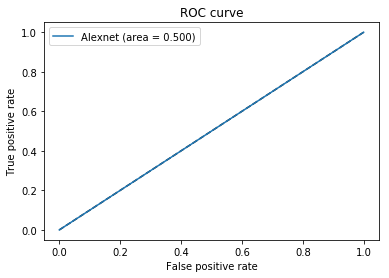

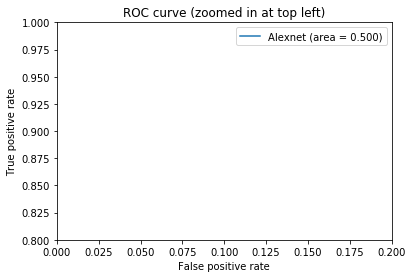

In [13]:
y_pred_probs = model.predict(test_dataset)
print(y_pred_probs.shape)
# Test metrics
fpr_test, tpr_test, thresholds_test = roc_curve((np.argmax(test_labels,1)), (np.argmax(y_pred_probs,1)))
auc_test = auc(fpr_test, tpr_test)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_test, tpr_test, label='Alexnet (area = {:.3f})'.format(auc_test))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_test, tpr_test, label='Alexnet (area = {:.3f})'.format(auc_test))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
#Checking gradient values of the loss wrt weights of last but one layer
weights = model.trainable_weights # weight tensors
grads = K.function([model.layers[0].input],K.gradients(model.layers[-1].output, weights[-2]))
gradients = grads([train_dataset])[0]
print(gradients)

In [ ]:
#Output values before activation in last layer
get_last_layer_output = K.function([model.layers[0].input],
                                  [model.layers[-2].output])
layer_output = get_last_layer_output([train_dataset])[0]
print(layer_output)

In [ ]:
test_results = model.evaluate(test_dataset, test_labels)
print ("Loss = " + str(test_results[0]))
print ("Test Accuracy = " + str(test_results[1]))

In [ ]:
for i in range(0,40):
    image = test_dataset[i,:]
    labels = test_labels[i]
    
    img_for_pred = np.ndarray(shape=(1,256,256,3))
    img_for_pred[0,:,:,:] = image
    pred_probs = model.predict(img_for_pred)
    
    #show misclassified examples
    
    if not(np.argmax(pred_probs) == np.argmax(labels)):
        print("\n")
        plt.imshow(np.array(image,np.int32))
        plt.show()
        
        print("Ground truth labels one hot encode: " + str(labels))
        print("Ground truth labels: " + str(np.argmax(labels)))

        print("Predicted Probability: " + str(pred_probs))
        print("Predicted Label: " + str(np.argmax(pred_probs)))
    
    